# Anisotropic Diffusion

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
SOBEL_X = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype="int32")

SOBEL_Y = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype="int32")

In [3]:
def AddNoise(img, mean=0, std=10):
    
    noise_factor = 1
    return img + noise_factor * np.random.normal(loc=mean, scale=std, size=img.shape)

def convolve(img, kernel):
    
    if kernel.shape[0] % 2 != 1 or kernel.shape[1] % 2 != 1:
        raise ValueError("Only odd dimensions on filter supported")

    img_height = img.shape[0]
    img_width = img.shape[1]
    pad_height = kernel.shape[0] // 2
    pad_width = kernel.shape[1] // 2
    
    pad = ((pad_height, pad_height), (pad_height, pad_width))
    g = np.empty(img.shape, dtype=np.float64)
    img = np.pad(img, pad, mode='constant', constant_values=0)
    
    for i in np.arange(pad_height, img_height+pad_height):
        for j in np.arange(pad_width, img_width+pad_width):
            RegOfInt = img[i - pad_height:i + pad_height + 1, j - pad_width:j + pad_width + 1]
            g[i - pad_height, j - pad_width] = (RegOfInt*kernel).sum()

    if (g.dtype == np.float64):
        kernel = kernel / 255.0
        kernel = (kernel*255).astype(np.uint8)
    else:
        g = g + abs(np.amin(g))
        g = g / np.amax(g)
        g = (g*255.0)
    return g

def Sobel(img):
    
    X = convolve(img, SOBEL_X)
    Y = convolve(img, SOBEL_Y)
    return X, Y

def Magnitude(X, Y):
    
    return (X*X + Y*Y)**(1/2)

def normalize255(img):
    
    M = np.zeros(img.shape)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            M[i,j] = ((img[i,j] - img.min())/(img.max() - img.min()))*255
    return M

def GetBHist(a):
    
    k = 0
    I = 0
    for i in range(a.shape[0]):
        k += a[i]
        if k/a.sum() >= 0.5:
            I = i+1
            break
    return I

def getB(img):
    
    P, Q = Sobel(img)

    M_0 = Magnitude(P, Q)
    M = np.zeros(img.shape)
    for i in range(1,img.shape[0]-1):
        for j in range(1,img.shape[1]-1):
            M[i-1,j-1] = M_0[i,j]

    M = normalize255(M)
    hist_fq, hist_range = np.histogram(M.reshape(img.shape[0]*img.shape[1]), bins = [i for i in range(1+int(M.max()))])
    B = GetBHist(hist_fq)
    return B

def g(x,B):
    
    return np.exp(-(x/B)**2)

def pixel_com(im, i, j, B, l=0.1):
    
    DN = im[i-1,j] - im[i,j]
    DS = im[i+1,j] - im[i,j]
    DE = im[i,j+1] - im[i,j]
    DW = im[i,j-1] - im[i,j] 

    cN = g(DN, B)
    cS = g(DS, B)
    cE = g(DE, B)
    cW = g(DW, B)

    return im[i,j] + l*(cN*DN + cS*DS + cE*DE + cW*DW)

ListOfImage = []

def AnisotropicDiffusion(image, itr=1):
    
    B = getB(image)
    A = np.zeros((image.shape[0]+2, image.shape[1]+2))

    for i in range(1,A.shape[0]-1):
        for j in range(1,A.shape[1]-1):
            A[i,j] = image[i-1,j-1]

    A2 = np.zeros(image.shape)

    for i in range(1,A.shape[0]-1):
        for j in range(1,A.shape[1]-1):
            A2[i-1,j-1] = pixel_com(A, i, j, B, l=0.2)
            
    ListOfImage.append(A2)
    
    if itr>1:
        for i in range(itr-1):
            A2 = AnisotropicDiffusion(A2)

    return A2

Text(0.5, 1.0, 'Noisy Image')

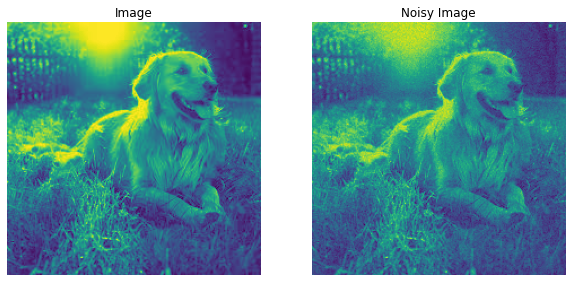

In [4]:
img = cv2.imread('E:\Dataset\dog.jpg', cv2.IMREAD_GRAYSCALE)
img_noisy = AddNoise(img, std=10)

fig = plt.figure(figsize=(10, 9))
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(img)
plt.axis('off')
plt.title("Image")

fig.add_subplot(rows, columns, 2)
plt.imshow(img_noisy)
plt.axis('off')
plt.title("Noisy Image")

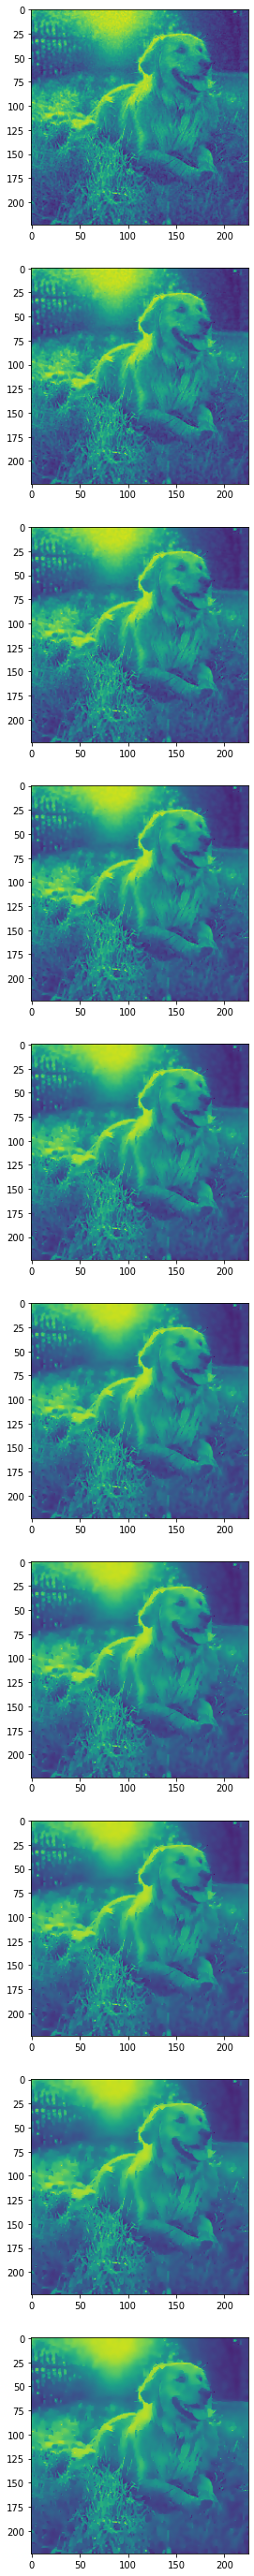

In [5]:
itr = 10
As = AnisotropicDiffusion(img_noisy, itr)

if len(ListOfImage)==1:
    f, ax = plt.subplots(len(ListOfImage), figsize =(10,10))
    ax.imshow(ListOfImage[0])
else:
    f, ax = plt.subplots(len(ListOfImage), figsize =(50,50))
    for i in range(len(ListOfImage)):
        ax[i].imshow(ListOfImage[i])

Text(0.5, 1.0, 'Anisotropic Diffusion of noisy image after 10 iteration')

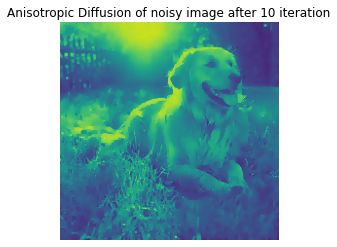

In [6]:
plt.imshow(As)
plt.axis('off')
plt.title("Anisotropic Diffusion of noisy image after "+ str(itr)+ " iteration")